# In this notebook we will apply data augmentation to increase the number of records we have in the input dataset . The dataset has already undergone preprocessing.
### We already know there is data imbalance. GRP_0 has many more records than other groups. We need to explore techniques for data augmentation so other GROUPS have a better representation. In this notebook, we will do data augmentation with the help of synonyms. We use KNN to find the words nearest to the original word. We also use Part of Speech Tagging as another technique to find synonyms.

#### Then we iterate over the dataset and identify synonyms of one or more words found in each ticket - keeping the tickets relationship with the group intact. 

#### We add the new ticket description and the Group back to the dataset . 
#### We go through this process a couple of times after leaving out the GRP_0 which already has enough representation in the dataset

In [1]:
#!pip install wordcloud
#!pip install langdetect
#!pip install googletrans
#!pip install textblob
#!pip install spacy
#!python -m spacy download en
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md
#!python -m spacy download en_core_web_lg
#!pip install langid
#!pip install google_trans_new
#!pip uninstall googletrans
#!pip install gensim

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS 
#from langdetect import detect
from itertools import cycle
#import googletrans
#from googletrans import Translator
from google_trans_new import google_translator 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#from textblob import TextBlob
#from textblob.translate import NotTranslated
import random
import operator
import math
import tqdm
import time
import spacy
import json
import tensorflow as tf
#import langid 

### This section below contains  Useful Functions 
- As we find new functions, we will create them here.

In [3]:
## Tokenizing sentence into token for finding synonym.
def make_tokenizer(texts):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer()
    t.fit_on_texts(texts)
    return t


def loadEmbeddingMatrix(typeToLoad, vocab_dict):
    import gensim.models.keyedvectors as word2vec
    import gc

    # load different embedding file from Kaggle depending on which embedding
    # matrix we are going to experiment with
    if (typeToLoad == "gloveTwitter50d"):
        EMBEDDING_FILE = 'embeddings\glove-twitter-27b-50d/glove.twitter.27B.50d.txt'
        embed_size = 50
    elif (typeToLoad == "word2vec"):
        word2vecDict = word2vec.KeyedVectors.load_word2vec_format( "embeddings\GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)
        embed_size = 300
    elif (typeToLoad == "fasttext"):
        EMBEDDING_FILE = 'embeddings\\fasttext/wiki.simple.vec'
        embed_size = 300
    elif (typeToLoad == "glove840B300D"):
        EMBEDDING_FILE = 'embeddings\glove.840B.300d/glove.840B.300d.txt'
        embed_size = 300
    elif (typeToLoad == "glove6B300D"):
        EMBEDDING_FILE = 'embeddings\glove.6B\glove.6B.300d.txt'
        embed_size = 300
    elif (typeToLoad == "paragram"):
        EMBEDDING_FILE = 'embeddings\paragram_300_sl999\paragram_300_sl999.txt'
        embed_size = 300
    elif (typeToLoad == "wikiNews"):
        EMBEDDING_FILE = "embeddings\wiki-news-300d-1M\wiki-news-300d-1M.vec"
        embed_size = 300

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    if (typeToLoad in ["gloveTwitter50d", "fasttext"]):
        embeddings_index = dict()
        # Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE)
        for line in f:
            # split up line into an indexed array
            values = line.rstrip().rsplit(' ')  # line.split()
            # first index is word
            word = values[0]
            # store the rest of the values in the array as a new array
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs  # 50 dimensions
        f.close()
    elif (typeToLoad in ["glove840B300D", "paragram", "glove6B300D"]):
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding='latin'))
    elif (typeToLoad in ["wikiNews"]):
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o) > 100)
    else:
        embeddings_index = dict()
        for word in word2vecDict.wv.vocab:
            embeddings_index[word] = word2vecDict.word_vec(word)
    print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
    # We get the mean and standard deviation of the embedding weights so that we could maintain the
    # same statistics for the rest of our own random generated weights.
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(vocab_dict)
    # We are going to set the embedding size to the pretrained dimension as we are replicating it.
    # the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

    # With the newly created embedding matrix, we'll fill it up with the words that we have in both
    # our own dictionary and loaded pretrained embedding.
    embeddedCount = 0
    for word, i in vocab_dict.items():
        #i -= 1
        # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        # and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None:
            try :
                embedding_matrix[i] = embedding_vector
                embeddedCount += 1
            except IndexError:
                pass
    print('total embedded:', embeddedCount, 'common words')

    del embeddings_index
    gc.collect()

    # finally, return the embedding matrix
    return embedding_matrix

In [4]:
dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
#Panda option settings that will be applicable through out this notebook
pd.set_option('max_colwidth', 80)

# Some useful functions
# given a dataframe and a sort sequence, return back the sorted dataframe
def sort_df(df, arr):
    df.sort_values(by=arr, inplace=True, ascending=False)
    df = df.reset_index()
    df = df.drop('index', 1)
    df.index += 1
    return df

# given a sequence of attributes and a dataframe, return dataframe sorted by descending order of importance
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}).sort_values('feature_importance',
                        ascending = False).reset_index(drop = True)
    return df

In [5]:
mydata = pd.read_csv('datasets/input_data_after_preprocessing_for_dl.csv')
#mydata = pd.read_excel("datasets/input_data.xlsx")
#mydata = pd.read_pickle('datasets/preprocesseddata_mldl.pkl')

In [6]:
mydata.head()

,Unnamed: 0,Combined Description Cleaned,Assignment group
0,0,login issue user manager name checked the name in ad and reset password advi...,GRP_0
1,1,outlook received from hello team my are not in calendar can somebody please ...,GRP_0
2,2,cannot log in to received from hi i cannot on best,GRP_0
3,3,unable to access tool page,GRP_0
4,4,error,GRP_0


### Here we are setting the baseline accuracy for the original dataset after data cleansing but before any Data Augmentation. We use LR scores as the base. 

In [7]:
df_assignment_group_dist = mydata['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706
5,GRP_2,241,2.835294
6,GRP_19,215,2.529412
7,GRP_3,200,2.352941
8,GRP_6,184,2.164706
9,GRP_13,145,1.705882


c:\programdata\anaconda3\envs\tfnightly_py38\lib\site-packages\seaborn\categorical.py:1604: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  barfunc(barpos, self.statistic, self.width,


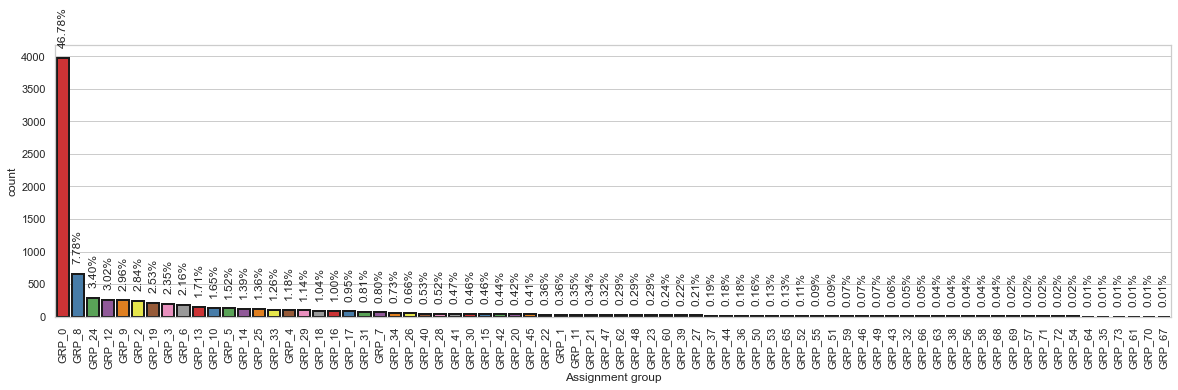

In [8]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
order = mydata["Assignment group"].value_counts().index

ax = sns.countplot(x="Assignment group", data=mydata, order=order, linewidth=2,
                  edgecolor = "k"*len(order), palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(mydata.index)*100, '.2f')+"%"), 
              (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom',
              rotation=90, xytext = (0, 10), textcoords = 'offset points')

In [9]:
df2 = mydata
le = preprocessing.LabelEncoder()
df2["LabelEncodings"] = le.fit_transform(df2["Assignment group"])
y_classes_len = len(le.classes_)
le.classes_
print(y_classes_len)

74


In [10]:
y = np.asarray(df2['LabelEncodings'])

In [11]:
mydata.isna().apply(pd.value_counts)

,Unnamed: 0,Combined Description Cleaned,Assignment group,LabelEncodings
False,8500,8500,8500,8500


In [12]:
#mydata.rename(columns = {'Combined description_ml':'Combined Description Cleaned'}, inplace = True) 

In [13]:
mydata['Combined Description Cleaned'] = mydata['Combined Description Cleaned'].replace(np.nan, '', regex=True)

In [14]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(mydata['Combined Description Cleaned'])
print(X_train_counts.shape)

(8500, 3481)


In [15]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(8500, 3481)


In [16]:
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=test_size)

In [17]:
print(len(count_vect.vocabulary_))

3481


In [18]:
print(X_train.shape)
print(y_train.shape)

(5950, 3481)
(5950,)


In [19]:
print(X_test.shape)
print(y_test.shape)

(2550, 3481)
(2550,)


In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
acc_score = accuracy_score(y_test, y_pred)
#print("Logistic Regression Score: ", acc_score)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
#print("Logistic Regression F1 Score: ", f1_score)
precision_score = metrics.precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
recall_score = metrics.recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
#print('f1 score: {:.2%}'.format(f1_score))
#print('Precison Score : {:.2%}'.format(precision_score))
#print('Recall score: {:.2%}'.format(recall_score))
dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
accuracy = accuracy_score(y_test, y_pred)
dfObj = dfObj.append({'Algorithm' : 'LR   {:.0%}'.format(test_size) + ' Raw Test Data after Cleansing' ,
                      'Accuracy': '{:.2%}'.format(accuracy),
                      'f1':'{:.2%}'.format(f1_score),
                      'Precision Score': '{:.2%}'.format(precision_score),
                      'Recall Score': '{:.2%}'.format(recall_score) 
                     } , ignore_index=True)

sort_by=['Accuracy', 'f1']
dfObj = sort_df(dfObj,sort_by)
dfObj

,Algorithm,Accuracy,f1,Precision Score,Recall Score
1,LR 30% Raw Test Data after Cleansing,61.25%,60.40%,64.05%,72.11%


### Data Augmentation using Word Embeddings

In [22]:
mydata['Combined Description Cleaned'] = mydata['Combined Description Cleaned'].astype(str)

tokenizer = make_tokenizer(mydata['Combined Description Cleaned'])

In [23]:

## Dictionary of word index
index_word = {}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

vocab_dict = tokenizer.word_index

In [24]:
vocab_dict

{'to': 1,
 'from': 2,
 'the': 3,
 'in': 4,
 'job': 5,
 'received': 6,
 'is': 7,
 'not': 8,
 'please': 9,
 'on': 10,
 'and': 11,
 'for': 12,
 'at': 13,
 'password': 14,
 'i': 15,
 'a': 16,
 'it': 17,
 'of': 18,
 'tool': 19,
 'with': 20,
 'schedule': 21,
 'no': 22,
 'this': 23,
 'reset': 24,
 'issue': 25,
 'unable': 26,
 'you': 27,
 'have': 28,
 'user': 29,
 'my': 30,
 'error': 31,
 'access': 32,
 'hello': 33,
 'be': 34,
 'account': 35,
 'can': 36,
 'that': 37,
 'working': 38,
 'company': 39,
 'help': 40,
 'ticket': 41,
 'am': 42,
 'when': 43,
 'network': 44,
 'are': 45,
 'system': 46,
 'cannot': 47,
 'login': 48,
 'need': 49,
 'outlook': 50,
 'as': 51,
 'but': 52,
 'vendor': 53,
 'message': 54,
 'power': 55,
 'we': 56,
 'was': 57,
 'does': 58,
 'me': 59,
 'do': 60,
 'an': 61,
 'all': 62,
 'below': 63,
 'see': 64,
 'able': 65,
 'hi': 66,
 'or': 67,
 'new': 68,
 'if': 69,
 'team': 70,
 'locked': 71,
 'out': 72,
 'down': 73,
 'outage': 74,
 'best': 75,
 'name': 76,
 'check': 77,
 'number':

In [25]:

## Loading word embedding
from time import time
start = time()
embed_mat = loadEmbeddingMatrix("glove840B300D", vocab_dict)
end = time()
print("Embedding loaded in ", (end-start)/60, "min")

Loaded 2196017 word vectors.
total embedded: 3497 common words
Embedding loaded in  2.202836275100708 min


In [26]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 20000

nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)

neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]

synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [27]:
#id_to_word = {id_: word for word, id_ in vocab_dict.items()}

In [28]:
#id_to_word

In [29]:
## Finding nearby synonym - Basically it's not actually synonym. It's near by words of targetted word. 
import nltk
from nltk.corpus import wordnet

synonym = {}
for x in range(0,len(index_word)):
    try :
        synonym.update({index_word[x] : [index_word[synonyms[x][i]] for i in range(synonyms_number-1)]})
    except :
        pass

In [30]:
synonym

{'to': ['able', 'way', 'can', 'make'],
 'from': ['out', 'this', 'up', 'to'],
 'the': ['of', 'one', 'same', 'that'],
 'in': ['into', 'the', 'place', 'within'],
 'job': ['work', 'working', 'looking', 'good'],
 'received': ['receive', 'given', 'sent', 'previously'],
 'is': ['which', 'be', 'one', 'only'],
 'not': ['should', 'be', 'but', 'would'],
 'please': ['ask', 'hesitate', 'here', 'you'],
 'on': ['out', 'the', 'off', 'up'],
 'and': ['well', 'both', 'with', 'as'],
 'for': ['and', 'making', 'with', 'well'],
 'at': ['time', 'as', 'up', 'around'],
 'password': ['login', 'user', 'encrypted', 'authentication'],
 'i': ['didnt', 'u', 'havent', 'dont'],
 'a': ['another', 'one', 'is', 'the'],
 'it': ['but', 'that', 'something', 'so'],
 'of': ['the', 'and', 'one', 'all'],
 'tool': ['easier', 'use', 'utility', 'easy'],
 'with': ['and', 'both', 'well', 'up'],
 'schedule': ['time', 'regular', 'resume', 'next'],
 'no': ['without', 'not', 'nothing', 'there'],
 'this': ['it', 'one', 'same', 'that'],
 '

In [31]:
## Use this synonym list to replace words with it's variation
## Below code is in draft. But logic can be used to complete the task

In [32]:
## Can only change words for selected part of speech to preserve semantic meaning.

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

def get_pos_tag (word, tagged) :
    res = [(x, y) for x, y in tagged if x == word]
    return res[0][1]

# Load the pretrained neural net
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [33]:
synonymX = {}
for desc in mydata["Combined Description Cleaned"]:
    #print(desc)
    # Tokenize the text
    tokenized = tokenizer.tokenize(desc)

    # Get the list of words from the entire text
    words = word_tokenize(desc)

    # Identify the parts of speech
    tagged = nltk.pos_tag(words, tagset="universal")
    
    replacements = []


    for word in words:
        synonym2 = []
        antonyms = []
        word_index = vocab_dict.get(word, None)

        pos_tag = get_pos_tag(word, tagged)
        if (word_index and pos_tag in ["ADJ", "ADV", "NOUN", "VERB"] and word not in nltk.corpus.stopwords.words('english')) :
            for syn in wordnet.synsets(word, eval("wordnet." + pos_tag)):
                for l in syn.lemmas() :
                    try:
                        if(l.name() in [index_word[synonyms[word_index][i]] for i in range(synonyms_number-1)]):
                            synonym2.append(l.name())
                    except KeyError:
                            print ('Key error')
                            print(l.name())
                    #if l.antonyms():
                    #    antonyms.append(l.antonyms()[0].name())
        
        if (synonym2) :
            #print("hello")
            synonymX.update({word : list(set(synonym2))})
            print(word, set(synonym2))

checked {'check'}
advised {'advise'}
confirmed {'confirm'}
resolved {'resolve'}
received {'receive'}
hello {'hi'}
kind {'sort'}
received {'receive'}
hi {'hello'}
best {'good', 'better'}
engineering {'technology'}
engineering {'technology'}
connected {'connect'}
received {'receive'}
hi {'hello'}
trying {'try'}
working {'work'}
home {'house'}
unlocking {'unlock'}
locked {'lock'}
received {'receive'}
hello {'hi'}
home {'house'}
connected {'connect'}
working {'work'}
getting {'get'}
need {'want'}
dynamics {'dynamic'}
regarding {'regard'}
best {'good', 'better'}
phone {'telephone'}
working {'work'}
received {'receive'}
hello {'hi'}
locked {'lock'}
client {'customer'}
duplication {'duplicate'}
received {'receive'}
gentle {'soft'}
trying {'try'}
display {'showing'}
assigned {'assign'}
set {'put'}
need {'want'}
corrected {'correct'}
flash {'flashing'}
resolve {'solve'}
assigned {'assign'}
engineering {'technology'}
need {'want'}
working {'work'}
needs {'need'}
resolved {'resolve'}
received {'r

locked {'lock'}
meeting {'meet'}
received {'receive'}
hello {'hi'}
best {'good', 'better'}
becomes {'become'}
received {'receive'}
create {'make'}
provide {'offer'}
locked {'lock'}
sent {'send'}
hi {'hello'}
getting {'get'}
resolution {'resolve'}
still {'even'}
received {'receive'}
set {'put'}
phone {'telephone'}
best {'good', 'better'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
logging {'log'}
installation {'installing'}
running {'run'}
need {'want'}
need {'want'}
engineering {'technology'}
connected {'connect'}
connected {'connect'}
received {'receive'}
phone {'telephone'}
best {'good', 'better'}
need {'want'}
need {'want'}
security {'protection'}
received {'receive'}
dynamics {'dynamic'}
global {'world'}
technology {'engineering'}
price {'cost'}
center {'middle'}
center {'middle'}
made {'make'}
need {'want'}
lost {'lose'}
works {'work'}
data {'information'}
going {'go'}
problem {'trouble'}
e

best {'good', 'better'}
received {'receive'}
longer {'long'}
phone {'telephone'}
customer {'client'}
telephone {'phone'}
received {'receive'}
times {'time'}
tried {'try'}
hour {'minute'}
met {'meet'}
received {'receive'}
coming {'come'}
told {'tell'}
mean {'think'}
home {'house'}
meeting {'meet'}
getting {'get'}
disabled {'disable'}
shown {'indicate'}
working {'work'}
client {'customer'}
attached {'attach'}
said {'say'}
working {'work'}
received {'receive'}
hello {'hi'}
facing {'face'}
meeting {'meet'}
problem {'trouble'}
fixed {'fix'}
regarding {'regard'}
showing {'show'}
told {'tell'}
investigating {'investigate'}
involve {'require'}
customer {'client'}
telephone {'phone'}
still {'even'}
working {'work'}
fixing {'fix'}
expiring {'expire'}
sent {'send'}
hello {'hi'}
days {'day'}
received {'receive'}
hello {'hi'}
support {'supporting'}
give {'make'}
permission {'permit'}
load {'loading'}
global {'world'}
customer {'client'}
telephone {'phone'}
block {'blocking'}
removed {'remove'}
need

received {'receive'}
home {'house'}
received {'receive'}
dynamics {'dynamic'}
received {'receive'}
good {'well'}
portion {'part'}
received {'receive'}
working {'work'}
working {'work'}
problem {'trouble'}
start {'starting', 'beginning'}
opening {'open'}
times {'time'}
fixed {'fix'}
phone {'telephone'}
home {'house'}
believe {'think'}
need {'want'}
received {'receive'}
needs {'need'}
received {'receive'}
trouble {'worry', 'problem'}
getting {'get'}
person {'someone'}
engineering {'technology'}
provided {'provide'}
trying {'try'}
corrupt {'corrupted'}
regarding {'regard'}
locked {'lock'}
find {'discover'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
getting {'get'}
certificate {'credential'}
trying {'try'}
ran {'run'}
quick {'fast'}
longer {'long'}
needs {'need'}
attached {'attach'}
good {'well'}
need {'want'}
connected {'connect'}
make {'give'}
received {'r

calling {'call'}
phone {'telephone'}
received {'receive'}
currently {'presently'}
space {'place'}
power {'force'}
power {'force'}
start {'begin'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
defective {'faulty'}
good {'well'}
need {'want'}
light {'clear'}
gray {'grey'}
built {'build'}
create {'make'}
provide {'offer'}
extended {'extend'}
extend {'expand'}
set {'put'}
problem {'trouble'}
take {'get', 'make'}
times {'time'}
often {'frequently'}
block {'blocking'}
stocks {'stock'}
example {'instance'}
problem {'trouble'}
find {'discover'}
cause {'reason'}
solve {'resolve'}
need {'want'}
space {'place'}
utilization {'usage'}
currently {'presently'}
received {'receive'}
resolve {'solve'}
connected {'connect'}
checked {'check'}
go {'get'}
connected {'connect'}
happening {'happen'}
working {'work'}
blocked {'block'}
received {'receive'}
need {'want'}
received {'receive'}
works {'work'}
process {'procedure'}
received {'receive'}
hi {'hello'}
assist {'

days {'day'}
yet {'even'}
find {'discover'}
checked {'check'}
attached {'attach'}
received {'receive'}
added {'add'}
received {'receive'}
power {'force'}
working {'work'}
received {'receive'}
simply {'just'}
problem {'trouble'}
space {'place'}
received {'receive'}
received {'receive'}
hi {'hello'}
need {'want'}
consultant {'advisor'}
finish {'end'}
cost {'price'}
center {'middle'}
set {'put'}
phone {'telephone'}
received {'receive'}
hi {'hello'}
assistance {'assist', 'aid', 'help'}
best {'good', 'better'}
look {'see'}
defective {'faulty'}
graphics {'graphic'}
engineering {'technology'}
taking {'take'}
showing {'show'}
customer {'client'}
telephone {'phone'}
unlocked {'unlock'}
best {'good', 'better'}
create {'make'}
provide {'offer'}
used {'use'}
received {'receive'}
received {'receive'}
good {'well'}
assist {'assistance', 'help'}
possibly {'perhaps'}
power {'force'}
data {'information'}
image {'picture'}
support {'supporting'}
scanning {'scan'}
problem {'trouble'}
directly {'immediate

phone {'telephone'}
interruption {'disruption'}
received {'receive'}
hi {'hello'}
assist {'assistance', 'help'}
attached {'attach'}
building {'build'}
find {'discover'}
telephony {'telephone'}
telephony {'telephone'}
possibly {'perhaps'}
need {'want'}
customer {'client'}
logging {'log'}
received {'receive'}
improve {'better'}
still {'even'}
getting {'get'}
received {'receive'}
late {'later'}
route {'road', 'path'}
forward {'ahead'}
supply {'provide'}
hello {'hi'}
problem {'trouble'}
late {'later'}
need {'want'}
needs {'need'}
received {'receive'}
quarter {'fourth'}
added {'add'}
appear {'seem'}
find {'discover'}
browse {'browsing'}
option {'choice'}
resolve {'solve'}
best {'good', 'better'}
power {'force'}
showing {'show'}
faulty {'incorrect', 'defective'}
received {'receive'}
communication {'communicating'}
protection {'security'}
view {'see'}
customer {'client'}
telephone {'phone'}
hello {'hi'}
reply {'answer'}
received {'receive'}
hi {'hello'}
received {'receive'}
getting {'get'}
fr

trying {'try'}
getting {'get'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
still {'even'}
received {'receive'}
support {'supporting'}
need {'want'}
attached {'attach'}
best {'good', 'better'}
create {'make'}
received {'receive'}
path {'way', 'route'}
look {'see'}
want {'need'}
notification {'notice'}
still {'even'}
old {'older'}
best {'good', 'better'}
received {'receive'}
hello {'hi'}
latest {'recent'}
problem {'trouble'}
best {'good', 'better'}
engineering {'technology'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
tier {'level'}
attached {'attach'}
received {'receive'}
dynamics {'dynamic'}
received {'receive'}
someone {'somebody'}
defective {'faulty'}
received {'receive'}
received {'receive'}
set {'put'}
measuring {'quantify'}
checked {'check'}
incorrectly {'wrong

received {'receive'}
received {'receive'}
power {'force'}
engineering {'technology'}
power {'force'}
start {'begin'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
received {'receive'}
received {'receive'}
extend {'expand'}
locked {'lock'}
reply {'answer'}
received {'receive'}
hi {'hello'}
entering {'enter'}
times {'time'}
daily {'everyday'}
best {'good', 'better'}
engineering {'technology'}
start {'starting', 'beginning'}
opening {'open'}
loading {'load'}
telephone {'phone'}
engineering {'technology'}
view {'see'}
days {'day'}
setting {'set'}
pro {'professional'}
needs {'need'}
phone {'telephone'}
hello {'hi'}
speak {'talk'}
list {'listing'}
moving {'move'}
keeping {'keep'}
need {'want'}
fixed {'fix'}
received {'receive'}
prerequisite {'requirement'}
client {'customer'}
support {'supporting'}
client {'customer'}
client {'customer'}
choose {'select'}
client {'customer'}
engineering {'technology'}
engineering {'technology'}
c

disconnected {'disconnect'}
audio {'sound'}
working {'work'}
dynamics {'dynamic'}
working {'work'}
attached {'attach'}
getting {'get'}
look {'looking'}
received {'receive'}
data {'information'}
found {'find'}
limit {'limitation'}
need {'want'}
create {'make'}
times {'time'}
note {'notice', 'mention'}
finally {'eventually'}
data {'information'}
checked {'check'}
colleague {'fellow'}
received {'receive'}
received {'receive'}
received {'receive'}
hello {'hi'}
received {'receive'}
home {'house'}
received {'receive'}
cause {'reason'}
problem {'trouble'}
impact {'affect'}
center {'middle'}
printing {'print'}
go {'get'}
resolve {'solve'}
received {'receive'}
need {'want'}
technology {'engineering'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
go {'get'}
home {'house'}
speak {'talk'}
received {'receive'}
hello {'hi'}
need {'want'}
engineering {'technology'}
received {'receive'}
late {

opening {'open'}
getting {'get'}
found {'find'}
view {'see'}
extend {'expand'}
received {'receive'}
start {'starting', 'beginning'}
currently {'presently'}
tried {'try'}
center {'middle'}
used {'use'}
global {'world'}
support {'supporting'}
ensure {'insure'}
assist {'help'}
setting {'set'}
potential {'possible'}
security {'protection'}
received {'receive'}
hello {'hi'}
support {'supporting'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
hello {'hi'}
best {'good', 'better'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
loading {'load'}
working {'work'}
getting {'get'}
problem {'trouble'}
almost {'nearly'}
printing {'print'}
returned {'return'}
provide {'offer'}
resolve {'solve'}
problem {'trouble'}
make {'give'}
model {'modeling', 'example'}
printing {'print'}
used {'use'}
problem {'trouble'}
respond {'answer'}
power {'force'}
currently {'p

picture {'image', 'pic', 'photo'}
center {'middle'}
fixed {'fix'}
hi {'hello'}
center {'middle'}
working {'work'}
someone {'somebody'}
person {'someone'}
problem {'trouble'}
got {'get'}
engineering {'technology'}
operating {'operate'}
need {'want'}
hello {'hi'}
facing {'face'}
resolve {'solve'}
away {'out', 'off'}
needs {'need'}
working {'work'}
provide {'offer'}
data {'information'}
getting {'get'}
authorized {'authorize'}
ticketing {'ticket'}
best {'good', 'better'}
printing {'print'}
measuring {'quantify'}
support {'supporting'}
lead {'leading'}
sent {'send'}
got {'get'}
need {'want'}
best {'good', 'better'}
need {'want'}
additional {'extra'}
checked {'check'}
sent {'send'}
old {'older'}
facing {'face'}
requirement {'prerequisite', 'necessary'}
problem {'trouble'}
working {'work'}
engineering {'technology'}
option {'choice'}
balancing {'balance'}
engineering {'technology'}
working {'work'}
received {'receive'}
best {'good', 'better'}
make {'give'}
model {'modeling', 'example'}
probl

working {'work'}
mill {'factory'}
model {'modeling', 'example'}
model {'modeling', 'example'}
starting {'start', 'begin'}
process {'procedure'}
selected {'select'}
best {'good', 'better'}
min {'minute'}
provide {'offer'}
person {'someone'}
best {'good', 'better'}
permission {'permit'}
quote {'quotation'}
model {'modeling', 'example'}
quote {'quotation'}
converted {'convert'}
giving {'give'}
getting {'get'}
power {'force'}
warning {'warn'}
create {'make'}
received {'receive'}
hello {'hi'}
shown {'indicate'}
problem {'trouble'}
best {'good', 'better'}
make {'give'}
model {'modeling', 'example'}
problem {'trouble'}
printing {'print'}
used {'use'}
problem {'trouble'}
printing {'print'}
respond {'answer'}
power {'force'}
ticketing {'ticket'}
working {'work'}
working {'work'}
telephony {'telephone'}
set {'put'}
displayed {'display'}
printed {'print'}
received {'receive'}
used {'use'}
received {'receive'}
working {'work'}
give {'make'}
permission {'permit'}
need {'want'}
printed {'print'}
qua

list {'listing'}
engineering {'technology'}
telephony {'telephone'}
client {'customer'}
getting {'get'}
resolution {'resolve'}
telephone {'phone'}
provide {'offer'}
phone {'telephone'}
confirmed {'confirm'}
quantity {'amount'}
confirming {'confirm'}
sent {'send'}
center {'middle'}
start {'starting', 'beginning'}
process {'procedure'}
seeing {'see'}
used {'use'}
made {'make'}
example {'instance'}
looking {'look'}
partially {'partly'}
confirmed {'confirm'}
showing {'show'}
provided {'provide'}
make {'give'}
data {'information'}
credential {'certificate'}
data {'information'}
listed {'list'}
switched {'switch'}
logged {'log'}
entering {'enter'}
checked {'check'}
confirmed {'confirm'}
home {'house'}
hello {'hi'}
effective {'efficient'}
logging {'log'}
logged {'log'}
attached {'attach'}
person {'someone'}
person {'someone'}
connected {'connect'}
confirmed {'confirm'}
resolved {'resolve'}
loaded {'load'}
received {'receive'}
assistance {'assist', 'aid', 'help'}
trying {'try'}
sent {'send'}
h

locked {'lock'}
received {'receive'}
trying {'try'}
listed {'list'}
engineering {'technology'}
technology {'engineering'}
problem {'trouble'}
received {'receive'}
hello {'hi'}
sending {'send'}
connected {'connect'}
problem {'trouble'}
set {'put'}
regarding {'regard'}
getting {'get'}
certificate {'credential'}
balancing {'balance'}
working {'work'}
locked {'lock'}
logged {'log'}
state {'country'}
locked {'lock'}
locked {'lock'}
locked {'lock'}
customer {'client'}
telephone {'phone'}
center {'middle'}
received {'receive'}
hi {'hello'}
getting {'get'}
telling {'tell'}
working {'work'}
want {'need'}
repair {'fix'}
phone {'telephone'}
need {'want'}
switch {'switching'}
old {'older'}
tried {'try'}
times {'time'}
observing {'observe'}
load {'loading'}
phone {'telephone'}
received {'receive'}
good {'well'}
shop {'store'}
hello {'hi'}
topic {'subject'}
running {'run'}
trouble {'worry', 'problem'}
best {'good', 'better'}
need {'want'}
received {'receive'}
recall {'remember'}
requirement {'prereq

list {'listing'}
engineering {'technology'}
working {'work'}
customer {'client'}
telephone {'phone'}
home {'house'}
tried {'try'}
confirmed {'confirm'}
resolved {'resolve'}
got {'get'}
disconnected {'disconnect'}
tried {'try'}
unlocked {'unlock'}
confirmed {'confirm'}
resolved {'resolve'}
route {'road', 'path'}
customer {'client'}
telephone {'phone'}
customer {'client'}
telephone {'phone'}
option {'choice'}
received {'receive'}
hello {'hi'}
becoming {'become'}
fixing {'fix'}
received {'receive'}
still {'even'}
waiting {'wait'}
used {'use'}
connected {'connect'}
audio {'sound'}
audio {'sound'}
working {'work'}
set {'put'}
need {'want'}
cutting {'cut'}
currently {'presently'}
running {'run'}
displayed {'display'}
frequently {'often'}
working {'work'}
assist {'assistance', 'help'}
received {'receive'}
best {'good', 'better'}
received {'receive'}
needs {'need'}
working {'work'}
getting {'get'}
authorized {'authorize'}
ticketing {'ticket'}
attached {'attach'}
need {'want'}
received {'receiv

repair {'fix'}
resolve {'solve'}
defective {'faulty'}
found {'find'}
working {'work'}
getting {'get'}
attached {'attach'}
create {'make'}
blocked {'block'}
client {'customer'}
old {'older'}
need {'want'}
received {'receive'}
sent {'send'}
working {'work'}
telephony {'telephone'}
assign {'specify'}
telephony {'telephone'}
phone {'telephone'}
need {'want'}
global {'world'}
seen {'see'}
engineering {'technology'}
received {'receive'}
make {'give'}
customer {'client'}
option {'choice'}
entry {'entering'}
resolve {'solve'}
problem {'trouble'}
best {'good', 'better'}
received {'receive'}
hi {'hello'}
permission {'permit'}
problem {'trouble'}
shop {'store'}
amount {'quantity'}
wrongly {'incorrectly'}
received {'receive'}
video {'picture'}
customer {'client'}
returned {'return'}
find {'discover'}
program {'plan'}
need {'want'}
give {'make'}
build {'construct'}
look {'see'}
stopping {'stop'}
map {'mapping'}
shipping {'ship'}
customer {'client'}
process {'procedure'}
fault {'mistake'}
hello {'hi

inquiry {'enquiry'}
space {'place'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
primary {'main'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
received {'receive'}
received {'receive'}
block {'blocking'}
received {'receive'}
blocked {'block'}
received {'receive'}
certificate {'credential'}
received {'receive'}
received {'receive'}
received {'receive'}
best {'good', 'better'}
received {'receive'}
received {'receive'}
engineering {'technology'}
received {'receive'}
hello {'hi'}
trouble {'worry', 'problem'}
best {'good', 'better'}
locked {'lock'}
received {'receive'}
power {'force'}
power {'force'}
start {'begin'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
received {'receive'}
received {'receive'}
certificate {'credential'}
problem {'trouble'}
solve {'resolve'}
received {'receive'}
received {'receive'}
running {'run'}


currently {'presently'}
received {'receive'}
good {'well'}
need {'want'}
added {'add'}
assist {'help'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
hello {'hi'}
used {'use'}
saved {'save'}
best {'good', 'better'}
locked {'lock'}
synchronized {'sync'}
received {'receive'}
hello {'hi'}
data {'information'}
currently {'presently'}
received {'receive'}
understand {'realize'}
almost {'nearly'}
making {'make'}
global {'world'}
process {'procedure'}
telephone {'phone'}
needs {'need'}
hi {'hello'}
assigned {'assign'}
need {'want'}
received {'receive'}
working {'work'}
problem {'trouble'}
returned {'return'}
provide {'offer'}
resolve {'solve'}
make {'give'}
model {'modeling', 'example'}
fixed {'fix'}
used {'use'}
problem {'trouble'}
respond {'answer'}
power {'force'}
ticketing {'ticket'}
confirmed {'confirm'}
purchase {'buy'}
go {'get'}
bigger {'big'}
instead {'rather'}
compare {'compa

notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
global {'world'}
additional {'extra'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
global {'world'}
additional {'extra'}
mill {'factory'}
power {'force'}
light {'clear'}
data {'information'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
kind {'sort'}
phone {'telephone'}
need {'want'}
theme {'idea'}
saving {'save'}
working {'work'}
connected {'connect'}
working {'work'}
resolved {'resolve'}
connected {'connect'}
seen {'see'}
need {'wa

incorrect {'wrong'}
engineering {'technology'}
customer {'client'}
telephone {'phone'}
locked {'lock'}
customer {'client'}
telephone {'phone'}
received {'receive'}
received {'receive'}
locked {'lock'}
data {'information'}
old {'older'}
received {'receive'}
hello {'hi'}
want {'need'}
especially {'particularly'}
engineering {'technology'}
locked {'lock'}
received {'receive'}
received {'receive'}
received {'receive'}
warning {'warn'}
showing {'show'}
received {'receive'}
best {'good', 'better'}
security {'protection'}
component {'element'}
process {'procedure'}
space {'place'}
space {'place'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
traveling {'travel', 'trip'}
days {'day'}
received {'receive'}
customer {'client'}
telephone {'phone'}
starting {'start', 'begin'}
global {'world'}
installation {'installing'}
power {'force'}
sent {'send'}
received {'receive'}
received {'receive'}
received

take {'get', 'make'}
look {'looking'}
customer {'client'}
telephone {'phone'}
needs {'need'}
hi {'hello'}
involved {'involve'}
eventually {'finally'}
seeing {'see'}
received {'receive'}
good {'well'}
difficulty {'trouble'}
looking {'look'}
getting {'get'}
problem {'trouble'}
problem {'trouble'}
light {'lighter'}
look {'see'}
received {'receive'}
license {'permit', 'permission'}
dynamics {'dynamic'}
phone {'telephone'}
video {'picture'}
need {'want'}
customer {'client'}
telephone {'phone'}
moving {'move'}
tried {'try'}
locked {'lock'}
unlocking {'unlock'}
resolved {'resolve'}
received {'receive'}
working {'work'}
primary {'main'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
needs {'need'}
need {'want'}
safety {'safe'}
shipping {'ship'}
received {'receive'}
times {'time'}
received {'receive'}
saying {'say'}
taking {'take'}
look {'see'}
problem {'trouble'}
wo

space {'place'}
received {'receive'}
hi {'hello'}
shutting {'shut'}
start {'starting', 'beginning'}
tried {'try'}
charging {'charge'}
currently {'presently'}
totally {'completely'}
working {'work'}
received {'receive'}
extending {'extend'}
sent {'send'}
hello {'hi'}
need {'want'}
extend {'expand'}
start {'begin'}
humanity {'mankind'}
mankind {'humanity'}
wrench {'pull'}
engineering {'technology'}
received {'receive'}
used {'use'}
working {'work'}
resolve {'solve'}
best {'good', 'better'}
phone {'telephone'}
received {'receive'}
received {'receive'}
days {'day'}
loading {'load'}
displayed {'display'}
alarm {'alert'}
telephone {'phone'}
disconnection {'disconnect'}
display {'showing'}
locked {'lock'}
customer {'client'}
telephone {'phone'}
needs {'need'}
connected {'connect'}
resolved {'resolve'}
checked {'check'}
advised {'advise'}
confirmed {'confirm'}
resolved {'resolve'}
global {'world'}
received {'receive'}
hi {'hello'}
told {'tell'}
working {'work'}
trying {'try'}
vacation {'holida

start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
found {'find'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
sent {'send'}
hello {'hi'}
received {'receive'}
list {'listing'}
list {'listing'}
hi {'hello'}
received {'receive'}
create {'make'}
notification {'notice'}
received {'receive'}
engineering {'technology'}
received {'receive'}
hello {'hi'}
getting {'get'}
received {'receive'}
received {'receive'}
home {'house'}
solve {'resolve'}
received {'receive'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
add

power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
received {'receive'}
process {'procedure'}
fix {'fixing'}
engineering {'technology'}
hi {'hello'}
charging {'charge'}
connected {'connect'}
need {'want'}
region {'area'}
create {'make'}
telephone {'phone'}
working {'work'}
engineering {'technology'}
security {'protection'}
working {'work'}
start {'begin'}
engineering {'technology'}
working {'work'}
received {'receive'}
hello {'hi'}
facing {'face'}
support {'supporting'}
repair {'fix'}
hello {'hi'}
unlocked {'unlock'}
problem {'trouble'}
hi {'hello'}
logged {'log'}
find {'discover'}
give {'make'}
phone {'telephone'}
understand {'realize'}
received {'receive'}
image {'picture'}
locked {'lock'}
received {'receive'}
hi {'hello'}
want {'need'}
think {'guess'}
need {'want'}
kind {'sort'}
received {'receive'}
list {'listing'}
received {'receive'}
hello {'hi'}
example {'instance'}
support {'supporting'}
security {'protect

confirmed {'confirm'}
resolved {'resolve'}
regarding {'regard'}
need {'want'}
expiring {'expire'}
need {'want'}
removed {'remove'}
need {'want'}
balancing {'balance'}
source {'reference'}
involved {'involve'}
assistance {'assist', 'aid', 'help'}
need {'want'}
getting {'get'}
received {'receive'}
need {'want'}
confirmed {'confirm'}
received {'receive'}
need {'want'}
confirmed {'confirm'}
engineering {'technology'}
reply {'answer'}
center {'middle'}
received {'receive'}
need {'want'}
best {'good', 'better'}
quick {'fast'}
quote {'quotation'}
thus {'therefore', 'hence'}
making {'make'}
client {'customer'}
loading {'load'}
got {'get'}
problem {'trouble'}
shop {'store'}
image {'picture'}
attached {'attach'}
center {'middle'}
received {'receive'}
regarding {'regard'}
provide {'offer'}
reply {'answer'}
center {'middle'}
received {'receive'}
hello {'hi'}
still {'even'}
waiting {'wait'}
problem {'trouble'}
need {'want'}
security {'protection'}
posted {'post'}
working {'work'}
going {'go'}
recei

want {'need'}
locked {'lock'}
received {'receive'}
hi {'hello'}
engineering {'technology'}
installation {'installing'}
problem {'trouble'}
engineering {'technology'}
source {'reference'}
blocked {'block'}
problem {'trouble'}
scanning {'scan'}
received {'receive'}
currently {'presently'}
remedy {'rectify'}
registered {'register'}
installation {'installing'}
received {'receive'}
best {'good', 'better'}
scanning {'scan'}
received {'receive'}
best {'good', 'better'}
locked {'lock'}
locked {'lock'}
received {'receive'}
unblock {'unfreeze'}
received {'receive'}
working {'work'}
person {'someone'}
problem {'trouble'}
model {'modeling', 'example'}
scanning {'scan'}
hello {'hi'}
need {'want'}
scanning {'scan'}
path {'way', 'route'}
opening {'open'}
power {'force'}
customer {'client'}
telephone {'phone'}
received {'receive'}
hi {'hello'}
hi {'hello'}
genuine {'true'}
received {'receive'}
good {'well'}
kind {'sort'}
look {'see'}
working {'work'}
power {'force'}
working {'work'}
turn {'turning'}
l

running {'run'}
running {'run'}
license {'permit', 'permission'}
inquiry {'enquiry'}
working {'work'}
need {'want'}
need {'want'}
customer {'client'}
telephone {'phone'}
locked {'lock'}
make {'give'}
needs {'need'}
got {'get'}
transferred {'transfer'}
set {'put'}
old {'older'}
added {'add'}
build {'construct'}
days {'day'}
fixed {'fix'}
engineering {'technology'}
tried {'try'}
reply {'answer'}
engineering {'technology'}
telephone {'phone'}
defective {'faulty'}
display {'showing'}
barely {'hardly', 'just'}
working {'work'}
home {'house'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
calculated {'calculate'}
received {'receive'}
received {'receive'}
need {'want'}
earnings {'profit'}
sending {'send'}
getting {'get'}
received {'receive'}
hello {'hi'}
printing {'print'}
sent {'send'}
best {'good', 'better'}
received {'receive'}
price {'cost'}
best {'good', 'better'}
best {'good', 'better'}
blocked {'block'}
received {'receive'}
need {'want'}
best {'good

global {'world'}
additional {'extra'}
connected {'connect'}
confirmed {'confirm'}
resolved {'resolve'}
connected {'connect'}
connected {'connect'}
received {'receive'}
hello {'hi'}
need {'want'}
getting {'get'}
phone {'telephone'}
linked {'link'}
create {'make'}
quantity {'amount'}
price {'cost'}
someone {'somebody'}
received {'receive'}
customer {'client'}
price {'cost'}
path {'way', 'route'}
usually {'normally'}
go {'get'}
home {'house'}
loading {'load'}
checked {'check'}
advised {'advise'}
confirmed {'confirm'}
resolved {'resolve'}
posted {'post'}
display {'showing'}
need {'want'}
kind {'sort'}
sent {'send'}
make {'give'}
problem {'trouble'}
create {'make'}
reverse {'reversal'}
movement {'move'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
hello {'hi'}
technology {'engineering'}
create {'make'}
need {'want'}
create {'make'}
structured {'structure'}
higher {'high'}
saving {'save'}
attached {'attach'}
listing {'list'}
needs {

received {'receive'}
give {'make'}
best {'good', 'better'}
notification {'notice'}
telephony {'telephone'}
received {'receive'}
hi {'hello'}
received {'receive'}
find {'discover'}
shortly {'soon'}
hello {'hi'}
think {'guess'}
hello {'hi'}
transportation {'transport', 'transit'}
transportation {'transport', 'transit'}
left {'leave'}
received {'receive'}
transferred {'transfer'}
example {'instance'}
confirmed {'confirm'}
usually {'normally'}
transferred {'transfer'}
need {'want'}
confirming {'confirm'}
process {'procedure'}
example {'instance'}
raised {'raise'}
received {'receive'}
find {'discover'}
locked {'lock'}
received {'receive'}
center {'middle'}
received {'receive'}
received {'receive'}
good {'well'}
appear {'seem'}
kind {'sort'}
icon {'image'}
amount {'quantity'}
find {'discover'}
received {'receive'}
hello {'hi'}
scanning {'scan'}
best {'good', 'better'}
shown {'indicate'}
posted {'post'}
problem {'trouble'}
working {'work'}
engineering {'technology'}
received {'receive'}
hello

old {'older'}
look {'looking'}
printing {'print'}
process {'procedure'}
found {'find'}
appear {'seem'}
received {'receive'}
amount {'quantity'}
need {'want'}
travel {'traveling'}
start {'starting', 'beginning'}
received {'receive'}
received {'receive'}
need {'want'}
received {'receive'}
hello {'hi'}
hi {'hello'}
problem {'trouble'}
problem {'trouble'}
person {'someone'}
best {'good', 'better'}
hi {'hello'}
displayed {'display'}
want {'need'}
display {'showing'}
best {'good', 'better'}
find {'discover'}
printing {'print'}
waiting {'wait'}
coming {'come'}
running {'run'}
phone {'telephone'}
component {'element'}
working {'work'}
author {'writer'}
author {'writer'}
getting {'get'}
flickering {'flicker'}
hello {'hi'}
often {'frequently'}
start {'begin'}
client {'customer'}
working {'work'}
hi {'hello'}
find {'discover'}
engineering {'technology'}
working {'work'}
need {'want'}
received {'receive'}
received {'receive'}
received {'receive'}
create {'make'}
colleague {'fellow'}
newly {'new'}


received {'receive'}
received {'receive'}
received {'receive'}
global {'world'}
provide {'offer'}
received {'receive'}
queries {'query'}
received {'receive'}
hi {'hello'}
need {'want'}
raising {'raise'}
switch {'switching'}
left {'leave'}
locked {'lock'}
hello {'hi'}
switch {'switching'}
advised {'advise'}
resolved {'resolve'}
opening {'open'}
received {'receive'}
locked {'lock'}
apply {'use'}
working {'work'}
balancing {'balance'}
working {'work'}
balancing {'balance'}
working {'work'}
balancing {'balance'}
received {'receive'}
logging {'log'}
times {'time'}
received {'receive'}
old {'older'}
locked {'lock'}
received {'receive'}
hello {'hi'}
need {'want'}
blocked {'block'}
reading {'read'}
process {'procedure'}
phone {'telephone'}
received {'receive'}
received {'receive'}
take {'get', 'make'}
problem {'trouble'}
best {'good', 'better'}
working {'work'}
hello {'hi'}
received {'receive'}
hello {'hi'}
need {'want'}
best {'good', 'better'}
received {'receive'}
working {'work'}
kingdom {'r

give {'make'}
got {'get'}
auto {'car'}
engineering {'technology'}
phone {'telephone'}
received {'receive'}
communication {'communicating'}
protection {'security'}
view {'see'}
giving {'give'}
attached {'attach'}
worse {'bad'}
opening {'open'}
hello {'hi'}
best {'good', 'better'}
switch {'switching'}
received {'receive'}
getting {'get'}
resolve {'solve'}
best {'good', 'better'}
locked {'lock'}
received {'receive'}
locked {'lock'}
getting {'get'}
facing {'face'}
worked {'work'}
support {'supporting'}
resolve {'solve'}
telephony {'telephone'}
installation {'installing'}
received {'receive'}
best {'good', 'better'}
adoption {'acceptance'}
received {'receive'}
find {'discover'}
snap {'grab'}
notification {'notice'}
telephony {'telephone'}
received {'receive'}
hi {'hello'}
phone {'telephone'}
list {'listing'}
affected {'affect'}
notification {'notice'}
telephony {'telephone'}
received {'receive'}
find {'discover'}
old {'older'}
watching {'watch'}
primary {'main'}
watching {'watch'}
hi {'hell

locked {'lock'}
locked {'lock'}
security {'protection'}
suspicious {'suspect'}
phone {'telephone'}
hello {'hi'}
working {'work'}
still {'even'}
find {'discover'}
find {'discover'}
start {'starting', 'beginning'}
received {'receive'}
engineering {'technology'}
subject {'topic'}
assistance {'assist', 'aid', 'help'}
kind {'sort'}
view {'see'}
customer {'client'}
shipping {'ship'}
believe {'think'}
added {'add'}
copied {'copy'}
corrected {'correct'}
need {'want'}
fixed {'fix'}
example {'instance'}
getting {'get'}
trying {'try'}
checked {'check'}
problem {'trouble'}
need {'want'}
phone {'telephone'}
view {'see'}
received {'receive'}
hello {'hi'}
engineering {'technology'}
received {'receive'}
good {'well'}
received {'receive'}
need {'want'}
engineering {'technology'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
notified {'notify'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
working {'work'}
getting {'get'}
video {'picture'}
create {'make'}
requ

finally {'eventually'}
got {'get'}
running {'run'}
received {'receive'}
needs {'need'}
phone {'telephone'}
phone {'telephone'}
global {'world'}
trying {'try'}
customer {'client'}
someone {'somebody'}
engineering {'technology'}
received {'receive'}
sending {'send'}
lower {'low'}
phone {'telephone'}
hello {'hi'}
received {'receive'}
dynamics {'dynamic'}
making {'make'}
attached {'attach'}
phone {'telephone'}
phone {'telephone'}
engineering {'technology'}
need {'want'}
assign {'specify'}
locked {'lock'}
engineering {'technology'}
permission {'permit'}
list {'listing'}
need {'want'}
tried {'try'}
list {'listing'}
phone {'telephone'}
tried {'try'}
unlocked {'unlock'}
confirmed {'confirm'}
resolved {'resolve'}
opening {'open'}
opening {'open'}
list {'listing'}
option {'choice'}
customer {'client'}
telephone {'phone'}
need {'want'}
needs {'need'}
resolved {'resolve'}
center {'middle'}
checked {'check'}
advised {'advise'}
confirmed {'confirm'}
resolved {'resolve'}
working {'work'}
customer {'c

saved {'save'}
sent {'send'}
seen {'see'}
client {'customer'}
hi {'hello'}
drawing {'draw'}
client {'customer'}
total {'amount'}
defective {'faulty'}
got {'get'}
data {'information'}
process {'procedure'}
found {'find'}
working {'work'}
locked {'lock'}
hear {'listen'}
received {'receive'}
find {'discover'}
need {'want'}
higher {'high'}
hello {'hi'}
working {'work'}
support {'supporting'}
higher {'high'}
provide {'offer'}
protection {'security'}
data {'information'}
installation {'installing'}
locked {'lock'}
defective {'faulty'}
image {'picture'}
hello {'hi'}
effective {'efficient'}
view {'see'}
effective {'efficient'}
view {'see'}
received {'receive'}
hello {'hi'}
find {'discover'}
displayed {'display'}
received {'receive'}
kind {'sort'}
showing {'show'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
additional {'extra'}
notification {'notice'}
hi {'hello'}
received {'receive'}
notification {'notice'}
sent {'send'}
vi

locked {'lock'}
need {'want'}
analyses {'analysis'}
attached {'attach'}
received {'receive'}
power {'force'}
start {'begin'}
power {'force'}
power {'force'}
dialing {'dial'}
working {'work'}
global {'world'}
global {'world'}
additional {'extra'}
received {'receive'}
received {'receive'}
received {'receive'}
received {'receive'}
connected {'connect'}
best {'good', 'better'}
received {'receive'}
make {'give'}
alarm {'alert'}
warning {'warn'}
need {'want'}
received {'receive'}
inquiry {'enquiry'}
phone {'telephone'}
need {'want'}
inquiry {'enquiry'}
received {'receive'}
need {'want'}
sent {'send'}
look {'see'}
received {'receive'}
sent {'send'}
tried {'try'}
phone {'telephone'}
hello {'hi'}
data {'information'}
old {'older'}
ensure {'insure'}
removed {'remove'}
ticketing {'ticket'}
section {'part'}
left {'leave'}
hi {'hello'}
writing {'write'}
forward {'ahead'}
ensure {'insure'}
closed {'close', 'shut'}
holiday {'vacation'}
best {'good', 'better'}
provide {'offer'}
start {'begin'}
model {

In [34]:
synonymX

{'checked': ['check'],
 'advised': ['advise'],
 'confirmed': ['confirm'],
 'resolved': ['resolve'],
 'received': ['receive'],
 'hello': ['hi'],
 'kind': ['sort'],
 'hi': ['hello'],
 'best': ['good', 'better'],
 'engineering': ['technology'],
 'connected': ['connect'],
 'trying': ['try'],
 'working': ['work'],
 'home': ['house'],
 'unlocking': ['unlock'],
 'locked': ['lock'],
 'getting': ['get'],
 'need': ['want'],
 'dynamics': ['dynamic'],
 'regarding': ['regard'],
 'phone': ['telephone'],
 'client': ['customer'],
 'duplication': ['duplicate'],
 'gentle': ['soft'],
 'display': ['showing'],
 'assigned': ['assign'],
 'set': ['put'],
 'corrected': ['correct'],
 'flash': ['flashing'],
 'resolve': ['solve'],
 'needs': ['need'],
 'days': ['day'],
 'taken': ['take'],
 'printed': ['print'],
 'picked': ['pick'],
 'daily': ['everyday'],
 'telephony': ['telephone'],
 'global': ['world'],
 'kept': ['keep'],
 'locking': ['lock'],
 'incorrect': ['wrong'],
 'meeting': ['meet'],
 'good': ['well'],
 'l

In [35]:
#newdf.to_csv('datasets/spaCy_Augmented_Data.csv') 

In [36]:
with open('datasets/word_embedding_synonyms_knn.json', 'w') as fp:
    json.dump(synonym, fp, sort_keys=True, indent=4)

In [37]:
with open('datasets/word_embedding_synonyms_pos.json', 'w') as fp:
    json.dump(synonym, fp, sort_keys=True, indent=4)

In [38]:
df = mydata[['Combined Description Cleaned', 'Assignment group'] ]
df = df[df['Assignment group'] != 'GRP_0']

In [39]:
df_assignment_group_dist = df['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_8,661,14.610964
1,GRP_24,289,6.388152
2,GRP_12,257,5.680813
3,GRP_9,252,5.570292
4,GRP_2,241,5.327144
5,GRP_19,215,4.752431
6,GRP_3,200,4.420866
7,GRP_6,184,4.067197
8,GRP_13,145,3.205128
9,GRP_10,140,3.094607


In [40]:
newdf = pd.DataFrame(columns = ['Combined Description Cleaned', 'Assignment group']) 
newdf 

,Combined Description Cleaned,Assignment group


In [41]:
i = 0

for index, row in df.iterrows(): 
    max_substitutions = 3
    i += 1
    if i > 30000: break
    desc = row['Combined Description Cleaned']
    assignment_grp = row['Assignment group']
    if max_substitutions > len(desc.split()):   # we are dealing with a small string
        if len(desc.split()) > 0:
            max_substitutions = 1
        else:
            max_substitutions = 0
    #print(max_substitutions)
    split_desc = desc.split()
    j=1
    while j <= max_substitutions:
        j+=1
        random_word = random.choice(split_desc)
        #print("Original sentence is %s ",  split_desc)
        #print("Picked word is %s", random_word)
        #print("Available substitutes %s",synonym.get(random_word,[random_word]) )
        substituted_word = random.choice(synonym.get(random_word,[random_word]))

        if random_word != substituted_word:
            new_desc = desc.replace(random_word, substituted_word , 1)
            #print("New sentence is %s ",  new_desc)
            newdf = newdf.append({'Combined Description Cleaned': new_desc, 'Assignment group': assignment_grp},ignore_index=True)


    #print(len(desc))
   
    #print (desc,assignment_grp ) 

#### Numbers after augmentation of the minority groups

In [42]:
df_assignment_group_dist = newdf['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_8,1979,14.936976
1,GRP_12,767,5.789116
2,GRP_9,756,5.706091
3,GRP_2,715,5.396634
4,GRP_24,654,4.936222
5,GRP_19,627,4.732433
6,GRP_3,592,4.468262
7,GRP_6,552,4.166352
8,GRP_13,433,3.268171
9,GRP_10,420,3.170051


In [43]:
df = mydata[['Combined Description Cleaned', 'Assignment group'] ]
augmented_df = df.append(newdf).drop_duplicates()

In [44]:
df_assignment_group_dist = augmented_df['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_0,3004,17.085656
1,GRP_8,1433,8.150381
2,GRP_12,972,5.528381
3,GRP_2,934,5.312251
4,GRP_19,828,4.709362
5,GRP_3,778,4.424980
6,GRP_24,766,4.356728
7,GRP_13,563,3.202139
8,GRP_14,458,2.604937
9,GRP_25,458,2.604937


c:\programdata\anaconda3\envs\tfnightly_py38\lib\site-packages\seaborn\categorical.py:1604: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  barfunc(barpos, self.statistic, self.width,


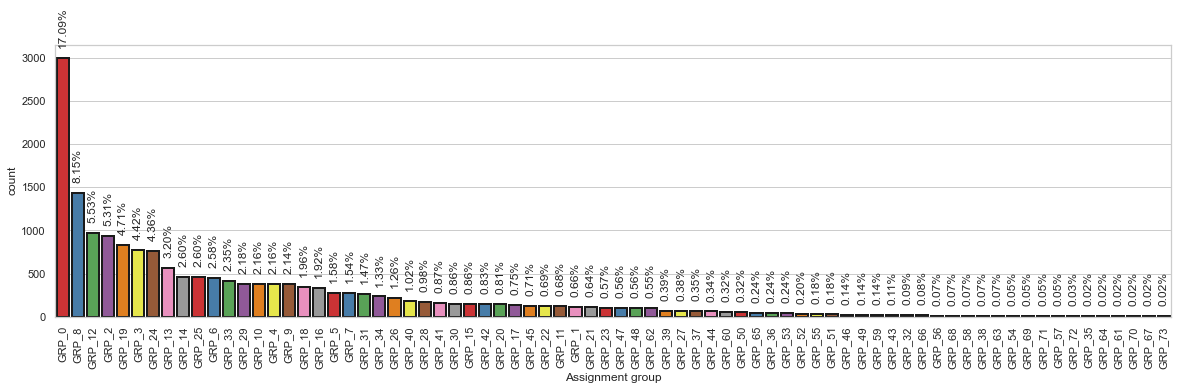

In [45]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
order = augmented_df["Assignment group"].value_counts().index

ax = sns.countplot(x="Assignment group", data=augmented_df, order=order, linewidth=2,
                  edgecolor = "k"*len(order), palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(augmented_df.index)*100, '.2f')+"%"), 
              (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom',
              rotation=90, xytext = (0, 10), textcoords = 'offset points')

### Observation
- After round 1 we see increased numbers for the minority groups.

In [46]:
df2 = augmented_df
le = preprocessing.LabelEncoder()
df2["LabelEncodings"] = le.fit_transform(augmented_df["Assignment group"])
y_classes_len = len(le.classes_)
le.classes_
print(y_classes_len)

74


In [47]:
y = np.asarray(df2['LabelEncodings'])

In [48]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(augmented_df['Combined Description Cleaned'])
print(X_train_counts.shape)

(17582, 3980)


In [49]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(17582, 3980)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=test_size)

In [51]:
print(len(count_vect.vocabulary_))

3980


In [52]:
print(X_train.shape)
print(y_train.shape)

(12307, 3980)
(12307,)


In [53]:
print(X_test.shape)
print(y_test.shape)

(5275, 3980)
(5275,)


In [54]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [55]:
acc_score = accuracy_score(y_test, y_pred)
print("Logistic Regression Score: ", acc_score)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print("Logistic Regression F1 Score: ", f1_score)
precision_score = metrics.precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
recall_score = metrics.recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print('f1 score: {:.2%}'.format(f1_score))
print('Precison Score : {:.2%}'.format(precision_score))
print('Recall score: {:.2%}'.format(recall_score))
#dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
accuracy = accuracy_score(y_test, y_pred)
dfObj = dfObj.append({'Algorithm' : 'LR   {:.0%}'.format(test_size) + ' Test Data after Data Augmentation Word Embedding Round 1' ,
                      'Accuracy': '{:.2%}'.format(accuracy),
                      'f1':'{:.2%}'.format(f1_score),
                      'Precision Score': '{:.2%}'.format(precision_score),
                      'Recall Score': '{:.2%}'.format(recall_score) 
                     } , ignore_index=True)

sort_by=['Accuracy', 'f1']
dfObj = sort_df(dfObj,sort_by)
dfObj

Logistic Regression Score:  0.6591469194312796
Logistic Regression F1 Score:  0.6550209267085775
f1 score: 65.50%
Precison Score : 71.84%
Recall score: 67.59%


,Algorithm,Accuracy,f1,Precision Score,Recall Score
1,LR 30% Test Data after Data Augmentation Word Embedding Round 1,65.91%,65.50%,71.84%,67.59%
2,LR 30% Raw Test Data after Cleansing,61.25%,60.40%,64.05%,72.11%


### Though we are doing this dataset augmentation for DL, we are running some ML models on this dataset just to be sure the data augmentation is helping

# Train a Support vector machine using the train set and get the accuracy on the test set

###### (Rubric) Use Gridsearch to find appropriate hyperparameters
###### (Rubric) Train model using the train data with hyper parameters obtained
###### (Rubric) Get accuracy and also view confusion matrix
###### (Rubric) Inferences based on accuracy/confusion matrix and other evaluation metrics of classification problem
###### (Rubric) Inferences based on the results
### Some Parameters we are trying the find the ideal values for:
- C is used during the training phase and says how much outliers are taken into account in calculating Support Vectors
- gamma  determines the radius of the area of influence of the support vectors if it is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting. When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data.
- kernel parameter selects the type of hyperplane used to separate the data.
-- We will let the Hypersearch determine the best kernel to use amoung
-- rbf : The RBF kernel is a stationary kernel. It is also known as the “squared exponential” kernel. 
-- poly : A polynomial kernel is a more generalized form of the linear kernel. The polynomial kernel can distinguish curved or nonlinear input space. The polynomial and RBF are especially useful when the data-points are not linearly separable.
-- sigmoid: The Sigmoid Kernel comes from the Neural Networks field, where the bipolar sigmoid function is often used as an activation function for artificial neurons
- probabiity: We will choose between True & False

In [56]:
#param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'],
#              'random_state': [1], 'probability': [True,False]}
#grid = GridSearchCV(SVC(),param_grid,refit=True,n_jobs=16,verbose=1)
#grid.fit(X_train,y_train)
#print(f'The best estimator is: \n {grid.best_estimator_}\n\n')
#grid_predictions = grid.predict(X_test)
#Fitting 5 folds for each of 96 candidates, totalling 480 fits
#C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
#  warnings.warn(("The least populated class in y has only %d"
#[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
#[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   47.1s
#[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  3.2min
#[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  9.4min
#[Parallel(n_jobs=16)]: Done 480 out of 480 | elapsed: 10.3min finished
#The best estimator is: 
# SVC(C=100, gamma=0.01, probability=True, random_state=1)

In [57]:
svc = SVC(C=100, gamma=0.1, probability=False, random_state=1)
clf = svc.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [58]:
f1_score_svc = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
precision_score_svc = metrics.precision_score(y_test, y_pred, average="macro")
recall_score_svc = metrics.recall_score(y_test, y_pred, average="macro")
print('f1 score: {:.2%}'.format(f1_score_svc))
print('Precison Score : {:.2%}'.format(precision_score_svc))
print('Recall score: {:.2%}'.format(recall_score_svc))
#dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
accuracy = metrics.accuracy_score(y_test, y_pred)
dfObj = dfObj.append({'Algorithm' : 'SVC   {:.0%}'.format(test_size) + ' Test Data after Data Augmentation Word Embedding Round 1' ,
                      'Accuracy': '{:.2%}'.format(accuracy),
                      'f1':'{:.2%}'.format(f1_score_svc),
                      'Precision Score': '{:.2%}'.format(precision_score_svc),
                      'Recall Score': '{:.2%}'.format(recall_score_svc) 
                     } , ignore_index=True)

sort_by=['Accuracy', 'f1']
dfObj = sort_df(dfObj,sort_by)
dfObj

f1 score: 87.29%
Precison Score : 91.84%
Recall score: 87.55%


c:\programdata\anaconda3\envs\tfnightly_py38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Algorithm,Accuracy,f1,Precision Score,Recall Score
1,SVC 30% Test Data after Data Augmentation Word Embedding Round 1,87.24%,87.29%,91.84%,87.55%
2,LR 30% Test Data after Data Augmentation Word Embedding Round 1,65.91%,65.50%,71.84%,67.59%
3,LR 30% Raw Test Data after Cleansing,61.25%,60.40%,64.05%,72.11%


### We will now persist the dataset for DL models to use 
- We will still proceed with one more round of augmentation

In [59]:
augmented_df.to_csv('datasets/input_data_after_data_for_dl__with_augmentation_knn_round1.csv') 

In [60]:
df = augmented_df[['Combined Description Cleaned', 'Assignment group']]
df = df[df['Assignment group'] != 'GRP_0']

In [61]:
df_assignment_group_dist = df['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_8,1433,9.829881
1,GRP_12,972,6.667581
2,GRP_2,934,6.406915
3,GRP_19,828,5.679791
4,GRP_3,778,5.336809
5,GRP_24,766,5.254493
6,GRP_13,563,3.861984
7,GRP_25,458,3.141720
8,GRP_14,458,3.141720
9,GRP_6,454,3.114282


In [62]:
newdf = pd.DataFrame(columns = ['Combined Description Cleaned', 'Assignment group']) 
newdf 

,Combined Description Cleaned,Assignment group


In [63]:
i = 0

for index, row in df.iterrows(): 
    max_substitutions = 3
    i += 1
    if i > 5000: break
    desc = row['Combined Description Cleaned']
    assignment_grp = row['Assignment group']
    if max_substitutions > len(desc.split()):   # we are dealing with a small string
        if len(desc.split()) > 0:
            max_substitutions = 1
        else:
            max_substitutions = 0
    #print(max_substitutions)
    split_desc = desc.split()
    j=1
    while j <= max_substitutions:
        j+=1
        random_word = random.choice(split_desc)
        #print("Original sentence is %s ",  split_desc)
        #print("Picked word is %s", random_word)
        #print("Available substitutes %s",synonym.get(random_word,[random_word]) )
        substituted_word = random.choice(synonym.get(random_word,[random_word]))

        if random_word != substituted_word:
            new_desc = desc.replace(random_word, substituted_word , 1)
            #print("New sentence is %s ",  new_desc)
            newdf = newdf.append({'Combined Description Cleaned': new_desc, 'Assignment group': assignment_grp},ignore_index=True)


    #print(len(desc))
   
    #print (desc,assignment_grp ) 

In [64]:
df_assignment_group_dist = newdf['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_8,1493,10.098072
1,GRP_2,1067,7.216774
2,GRP_12,999,6.756848
3,GRP_3,848,5.735543
4,GRP_19,792,5.356781
5,GRP_24,784,5.302672
6,GRP_13,589,3.983767
7,GRP_25,537,3.632060
8,GRP_33,496,3.354751
9,GRP_14,444,3.003044


In [65]:
df = augmented_df[['Combined Description Cleaned', 'Assignment group'] ]
augmented_df = df.append(newdf).drop_duplicates()

In [66]:
augmented_df

,Combined Description Cleaned,Assignment group
0,login issue user manager name checked the name in ad and reset password advi...,GRP_0
1,outlook received from hello team my are not in calendar can somebody please ...,GRP_0
2,cannot log in to received from hi i cannot on best,GRP_0
3,unable to access tool page,GRP_0
4,error,GRP_0
...,...,...
14780,setup o utility we,GRP_24
14781,setup o tool they,GRP_24
14782,setup ce tool they,GRP_24
14783,setup eu tool even,GRP_24


In [67]:
df_assignment_group_dist = augmented_df['Assignment group'].value_counts().reset_index()
df_assignment_group_dist['percentage'] = (df_assignment_group_dist['Assignment group']/df_assignment_group_dist['Assignment group'].sum())*100
df_assignment_group_dist.head(20)

,index,Assignment group,percentage
0,GRP_0,3004,9.648616
1,GRP_8,2806,9.012655
2,GRP_2,1921,6.170103
3,GRP_12,1891,6.073746
4,GRP_19,1542,4.952785
5,GRP_3,1541,4.949573
6,GRP_24,1406,4.515963
7,GRP_13,1125,3.613413
8,GRP_25,964,3.096293
9,GRP_14,874,2.807220


c:\programdata\anaconda3\envs\tfnightly_py38\lib\site-packages\seaborn\categorical.py:1604: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  barfunc(barpos, self.statistic, self.width,


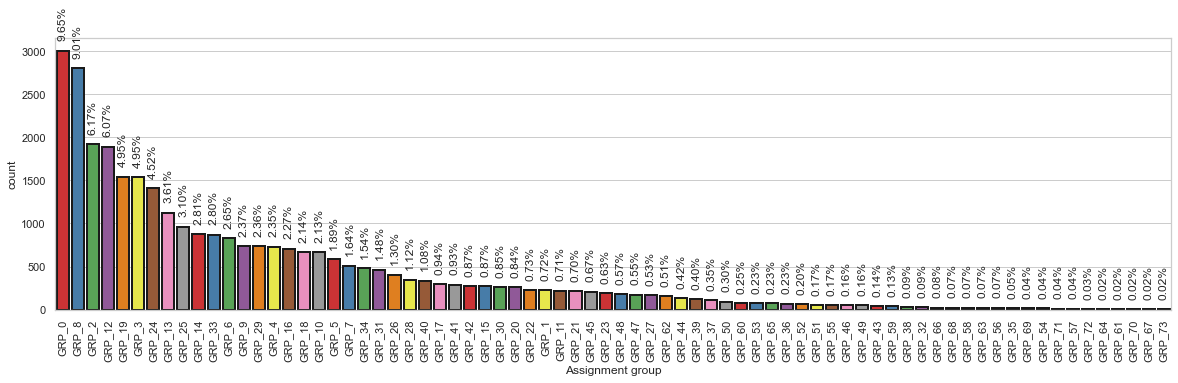

In [68]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
order = augmented_df["Assignment group"].value_counts().index

ax = sns.countplot(x="Assignment group", data=augmented_df, order=order, linewidth=2,
                  edgecolor = "k"*len(order), palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(augmented_df.index)*100, '.2f')+"%"), 
              (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom',
              rotation=90, xytext = (0, 10), textcoords = 'offset points')

# The numbers look good after round 2

In [69]:
df2 = augmented_df
le = preprocessing.LabelEncoder()
df2["LabelEncodings"] = le.fit_transform(augmented_df["Assignment group"])
y_classes_len = len(le.classes_)
le.classes_
print(y_classes_len)

74


In [70]:
y = np.asarray(df2['LabelEncodings'])

In [71]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(augmented_df['Combined Description Cleaned'])
print(X_train_counts.shape)

(31134, 4451)


In [72]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(31134, 4451)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.3)

In [74]:
print(len(count_vect.vocabulary_))

4451


In [75]:
print(X_train.shape)
print(y_train.shape)

(21793, 4451)
(21793,)


In [76]:
print(X_test.shape)
print(y_test.shape)

(9341, 4451)
(9341,)


In [77]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [78]:
acc_score = accuracy_score(y_test, y_pred)
print("Logistic Regression Score: ", acc_score)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print("Logistic Regression F1 Score: ", f1_score)
precision_score = metrics.precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
recall_score = metrics.recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print('f1 score: {:.2%}'.format(f1_score))
print('Precison Score : {:.2%}'.format(precision_score))
print('Recall score: {:.2%}'.format(recall_score))
#dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
accuracy = accuracy_score(y_test, y_pred)
dfObj = dfObj.append({'Algorithm' : 'LR   {:.0%}'.format(test_size) + ' Test Data after Data Augmentation Word Embedding Round 2' ,
                      'Accuracy': '{:.2%}'.format(accuracy),
                      'f1':'{:.2%}'.format(f1_score),
                      'Precision Score': '{:.2%}'.format(precision_score),
                      'Recall Score': '{:.2%}'.format(recall_score) 
                     } , ignore_index=True)

sort_by=['Accuracy', 'f1']
dfObj = sort_df(dfObj,sort_by)
dfObj

Logistic Regression Score:  0.7750776148164008
Logistic Regression F1 Score:  0.7731449235174563
f1 score: 77.31%
Precison Score : 80.07%
Recall score: 77.83%


,Algorithm,Accuracy,f1,Precision Score,Recall Score
1,SVC 30% Test Data after Data Augmentation Word Embedding Round 1,87.24%,87.29%,91.84%,87.55%
2,LR 30% Test Data after Data Augmentation Word Embedding Round 2,77.51%,77.31%,80.07%,77.83%
3,LR 30% Test Data after Data Augmentation Word Embedding Round 1,65.91%,65.50%,71.84%,67.59%
4,LR 30% Raw Test Data after Cleansing,61.25%,60.40%,64.05%,72.11%


In [79]:
svc = SVC(C=10, gamma=1, probability=False, random_state=1)
clf = svc.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [80]:
f1_score_svc = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
precision_score_svc = metrics.precision_score(y_test, y_pred, average="macro")
recall_score_svc = metrics.recall_score(y_test, y_pred, average="macro")
print('f1 score: {:.2%}'.format(f1_score_svc))
print('Precison Score : {:.2%}'.format(precision_score_svc))
print('Recall score: {:.2%}'.format(recall_score_svc))
#dfObj = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'f1', 'Precision Score', 'Recall Score'])
accuracy = metrics.accuracy_score(y_test, y_pred)
dfObj = dfObj.append({'Algorithm' : 'SVC   {:.0%}'.format(test_size) + ' Test Data after Data Augmentation Word Embedding Round 2' ,
                      'Accuracy': '{:.2%}'.format(accuracy),
                      'f1':'{:.2%}'.format(f1_score_svc),
                      'Precision Score': '{:.2%}'.format(precision_score_svc),
                      'Recall Score': '{:.2%}'.format(recall_score_svc) 
                     } , ignore_index=True)

sort_by=['Accuracy', 'f1']
dfObj = sort_df(dfObj,sort_by)
dfObj

f1 score: 91.37%
Precison Score : 94.15%
Recall score: 89.67%


c:\programdata\anaconda3\envs\tfnightly_py38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Algorithm,Accuracy,f1,Precision Score,Recall Score
1,SVC 30% Test Data after Data Augmentation Word Embedding Round 2,91.39%,91.37%,94.15%,89.67%
2,SVC 30% Test Data after Data Augmentation Word Embedding Round 1,87.24%,87.29%,91.84%,87.55%
3,LR 30% Test Data after Data Augmentation Word Embedding Round 2,77.51%,77.31%,80.07%,77.83%
4,LR 30% Test Data after Data Augmentation Word Embedding Round 1,65.91%,65.50%,71.84%,67.59%
5,LR 30% Raw Test Data after Cleansing,61.25%,60.40%,64.05%,72.11%


### We will now save the dataset for DL Models to use

In [81]:
augmented_df.to_csv('datasets/input_data_after_data_for_dl__with_augmentation_knn_round2.csv') 